# Simple Offline DTW

This notebook implements a simple offline DTW baseline system.  The only requirement in this notebook is that it implement the `offline_processing()` and `online_processing()` functions, which will be imported and run in `02_RunExperiment.ipynb`.  The rest of the notebook is for experimenting, visualizing, and analyzing the system, so it should be thought of as a sandbox for development.

Here is a summary of the offline DTW approach:
- Offline processing: The orchestra and full mix recordings are aligned with standard DTW using chroma features.
- Online processing: The solo piano and full mix recordings are aligned with standard DTW using chroma features, and the predicted alignment is then used to infer the corresponding alignment between the piano and orchestra recordings.  Note that this approach is not actually a valid online approach -- it serves primarily as a reference to gauge the effectiveness of other approaches.

## Offline Processing

In the offline processing stage, three things are computed and stored in the `cache/` folder:
- chroma features for the orchestra recording
- chroma features for the full mix recording
- predicted DTW alignment between the orchestra and full mix recordings

In [10]:
import numpy as np
import librosa as lb
import os
import os.path
import import_ipynb
import align_tools
import system_utils
from hmc_mir.align import dtw
from numba import jit, njit, prange

In [3]:
def offline_processing(scenario_dir, cache_dir, hop_length):
    '''
    Carries out offline processing for a simple offline DTW system.
    
    Inputs
    scenario_dir: The scenario directory to process
    cache_dir: The location of the cache directory
    hop_length: The hop length in samples used when computing chroma features
    steps: an L x 2 array specifying the allowable DTW transitions
    weights: a length L array specifying the DTW transition weights
    
    This function will store the computed chroma features and estimated alignment in the cache folder.
    '''
    
    # setup
    system_utils.verify_scenario_dir(scenario_dir)
    if os.path.exists(cache_dir):
        # print(f'{cache_dir} has already been processed.  Skipping.')
        pass
    else:
        # setup
        os.makedirs(cache_dir)

        # compute orchestra features
        o_file = f'{scenario_dir}/o.wav'
        y_o, sr = lb.core.load(o_file)
        F_o = lb.feature.chroma_cqt(y=y_o, sr=sr, hop_length=hop_length, norm=None) 

        # compute full mix features
        po_file = f'{scenario_dir}/po.wav'
        y_po, sr = lb.core.load(po_file)
        F_po = lb.feature.chroma_cqt(y=y_po, sr=sr, hop_length=hop_length, norm=None)
      
        # compute subsequence DTW alignment (orchestra as query) 
        orch_start_sec, orch_end_sec = system_utils.get_orchestra_start_end_times(scenario_dir)
        orch_start_frm = int(np.round(orch_start_sec * sr / hop_length))
        orch_end_frm = int(np.round(orch_end_sec * sr / hop_length)) + 1
        # wp = align_tools.compute_dtw_alignment(1 - F_o[:,orch_start_frm:orch_end_frm].T @ F_po, steps, weights, subseq = True)
        F_o = F_o[:,orch_start_frm:orch_end_frm]
        if F_o.shape[1] > F_po.shape[1]:
            raise ValueError('Orchestra is longer than full mix.  This is not supported.')

        C = align_tools.dtw_cost(F_o, F_po)
        _, _, wp = dtw.dtw(C, np.array([[1,1],[1,2],[2,1]]),[1,1,2], True)
        wp[0,:] = wp[0,:] + orch_start_frm  # account for offset

        # save to cache
        np.save(f'{cache_dir}/o_chroma.npy', F_o)
        np.save(f'{cache_dir}/po_chroma.npy', F_po)
        np.save(f'{cache_dir}/o_po_align.npy', wp)
    
    return

In [4]:
def verify_cache_dir(indir):
    '''
    Verifies that the specified cache directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/o_chroma.npy'), f'o_chroma.npy missing from {indir}'
    assert os.path.exists(f'{indir}/po_chroma.npy'), f'po_chroma.npy missing from {indir}'
    assert os.path.exists(f'{indir}/o_po_align.npy'), f'o_po_align.npy missing from {indir}'

# Online Processing

In the online processing stage, we do two things:
- compute an offline DTW alignment between the piano and full mix recordings,
- use the predicted alignment to infer the alignment between the piano and orchestra recordings

Note that this baseline system is not a valid online system since it uses offline DTW.  It merely serves as a reference comparison.

In [5]:
def online_processing(scenario_dir, out_dir, cache_dir, hop_length, steps, weights):
    '''
    Carries out `online' processing for a simple offline DTW system.
    
    Inputs
    scenario_dir: The scenario directory to process
    out_dir: The directory to put results, intermediate files, and logging info
    cache_dir: The cache directory
    hop_length: The hop length in samples used when computing chroma features
    steps: an L x 2 array specifying the allowable DTW transitions
    weights: a length L array specifying the DTW transition weights

    This function will compute and save the predicted alignment in the output directory in a file hyp.npy
    '''
    
    # verify & setup
    system_utils.verify_scenario_dir(scenario_dir)
    verify_cache_dir(cache_dir)
    assert not os.path.exists(out_dir), f'Output directory {out_dir} already exists.'
    os.makedirs(out_dir)
    
    # compute features
    p_file = f'{scenario_dir}/p.wav'
    y, sr = lb.core.load(p_file)
    F_p = lb.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length, norm=2)  # piano features
    F_po = np.load(f'{cache_dir}/po_chroma.npy') # full mix features
        
    # determine the start time of the query in the orchestra recording (ground truth)
    # hop_sec = hop_length / sr
    # orch_start_sec, _ = system_utils.get_orchestra_query_boundaries(scenario_dir)
    # orch_start_frm = orch_start_sec / hop_sec  # keep max precision, don't round
    
    # infer the start time of the query in the full mix recording (estimated)
    wp_BC = np.flipud(np.load(f'{cache_dir}/o_po_align.npy'))
    wp_BC = np.hstack((np.array([0,0]).reshape((2,-1)), wp_BC)) # prepend (0,0) to handle edge cases properly
    # fullmix_start_frm = int(np.round(np.interp(orch_start_frm, wp_BC[1,:], wp_BC[0,:])))
    
    # force the DTW alignment to start at the correct position
    # wp_AB = compute_fsve_dtw_alignment(F_p, F_po[:,fullmix_start_frm:], steps, weights)
    # wp_AB[1,:] = wp_AB[1,:] + fullmix_start_frm  # compensate for offset
    C = align_tools.dtw_cost(F_p, F_po)
    _, _, wp_AB = dtw.dtw(C, steps, weights, True)
    
    # infer piano-orchestra alignment
    wp_AC = align_tools.infer_alignment(wp_AB, wp_BC, frames=True)
    np.save(f'{out_dir}/hyp.npy', wp_AC*hop_sec)
    
    # save debugging info
    np.save(f'{out_dir}/orch_start_sec.npy', orch_start_sec)
    np.save(f'{out_dir}/fullmix_start_frm.npy', fullmix_start_frm)
    np.save(f'{out_dir}/p_po_align.npy', wp_AB)
    
    return

In [7]:
def verify_hyp_dir(indir):
    '''
    Verifies that the specified scenario hypothesis directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/hyp.npy')

# Example


Here is an example of how to call the offline and online processing functions on a scenario directory.

In [8]:
# scenario_dir = 'scenarios/s2'
# out_dir = 'experiments/test/s2'
# cache_dir = 'experiments/test/cache'
# hop_size = 512
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([2,3,3])
# offline_processing(scenario_dir, cache_dir, hop_size, steps, weights)
# online_processing(scenario_dir, out_dir, cache_dir, hop_size, steps, weights)

## Debugging

Some code for debugging the system.  Can delete later.

In [7]:
scenario_dir = 'scenarios/s2'
out_dir = 'experiments/debug/s2'
cache_dir = 'experiments/debug/cache'
hop_length = 512
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])

In [17]:
offline_processing(scenario_dir, cache_dir, hop_length)

(12, 29433) (12, 28184)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
o_file = f'{scenario_dir}/o.wav'
y_o, sr = lb.core.load(o_file)

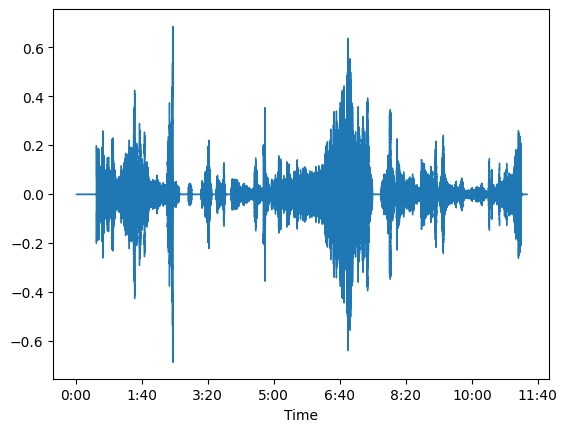

In [9]:
lb.display.waveshow(y_o, sr=sr)

In [11]:
#import matplotlib.pyplot as plt

In [12]:
# p_file = f'{scenario_dir}/p.wav'
# y, sr = lb.core.load(p_file)
# F_p = lb.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length, norm=2)  # piano features
# F_po = np.load(f'{cache_dir}/po_chroma.npy') # full mix features

In [13]:
# orch_start_sec, _ = get_orchestra_query_boundaries(scenario_dir)
# orch_start_frm = orch_start_sec / (hop_length / sr)  # keep max precision, don't round
# # infer the start time of the query in the full mix recording (estimated)
# wp_BC = np.load(f'{cache_dir}/po_o_align.npy')
# fullmix_start_frm = int(np.round(np.interp(orch_start_frm, wp_BC[1,:], wp_BC[0,:])))
# # force the DTW alignment to start at the correct position
# wp_AB = compute_fsve_dtw_alignment(F_p, F_po[:,fullmix_start_frm:], steps, weights)
# wp_AB[1,:] = wp_AB[1,:] + fullmix_start_frm  # compensate for offset
# # infer piano-orchestra alignment
# wp_AC = infer_alignment(wp_AB, wp_BC)     

In [14]:
# plt.plot(wp_AC[0,:]*hop_sec, wp_AC[1,:]*hop_sec)
# plt.grid()